<a href="https://colab.research.google.com/github/Binhcore/I2D/blob/main/%5BFULL_CODE%5D_Lecture_10_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages

In [ ]:
import numpy as np
import torch
import torch.nn as nn

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from tqdm.notebook import tqdm

### Define device and download image

In [ ]:
# Let's run with the GPU
device = 'cuda'

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg -O scream.jpg
!wget https://i.imgur.com/u13WTBg.jpg -O dog.jpg

--2022-01-27 22:48:29--  https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11403121 (11M) [image/jpeg]
Saving to: ‘scream.jpg’

scream.jpg          100%[===================>]  10.87M  6.46MB/s    in 1.7s    

2022-01-27 22:48:32 (6.46 MB/s) - ‘scream.jpg’ saved [11403121/11403121]

--2022-01-27 22:48:32--  https://i.imgur.com/u13WTBg.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.24.193
Connecting to i.imgur.com (i.imgur.com)|151.101.24.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153820 (150K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 150.21K 

### Define transform functions for image, and resize and normalize images

In [ ]:
img_size = 512
resizer = transforms.Resize((img_size, img_size))
to_tensor = transforms.ToTensor()
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

style_img = Image.open('./scream.jpg')
content_img = Image.open('./dog.jpg')

style_img_unnormalize = to_tensor(resizer(style_img)).to(device)
content_img_unnormalize = to_tensor(resizer(content_img)).to(device)

style_img_normalize = normalizer(style_img_unnormalize)
content_img_normalize = normalizer(content_img_unnormalize)


Text(0.5, 1.0, 'Content Image before normalization')

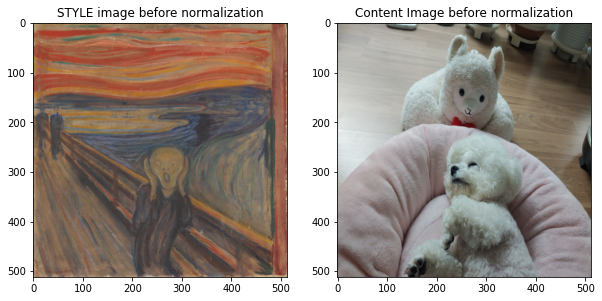

In [ ]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))
ax[0].imshow(style_img_unnormalize.permute(1, 2, 0).cpu())
ax[0].set_title('STYLE image before normalization')

ax[1].imshow(content_img_unnormalize.permute(1, 2, 0).cpu())
ax[1].set_title('Content Image before normalization')

### Load Pre-trained VGG

In [ ]:
# features containing the conv and pool layers (except fc layers)
vgg = models.vgg19(pretrained=True)
vgg = vgg.features.to(device)
for param in vgg.parameters():
    param.requires_grad_(False)

print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Function for getting feature at predefined layer index

In [ ]:
def get_features(vgg, x, require_idx = [0, 5, 10, 19, 21, 28]): # conv1_1, conv2_1, conv3_1, .....
    features = []
    for l_i, layer in enumerate(vgg):
        x = layer(x)
        if l_i in require_idx:
            features.append(x)
    return features

In [ ]:
features = get_features(vgg, x=torch.zeros(1, 3, 512, 512, ).to(device))
print([f.shape for f in features])

[torch.Size([1, 64, 512, 512]), torch.Size([1, 128, 256, 256]), torch.Size([1, 256, 128, 128]), torch.Size([1, 512, 64, 64]), torch.Size([1, 512, 64, 64]), torch.Size([1, 512, 32, 32])]


### Define our training variable

In [ ]:
target_img = copy.deepcopy(content_img_normalize)
target_img = target_img.requires_grad_(True)

In [ ]:
optimizer = torch.optim.Adam([target_img], lr=0.1)

### Define train function

In [ ]:
def train(target_img, content_img, style_img, vgg, optimizer):
    optimizer.zero_grad()
    vgg.eval()

    criterion = nn.MSELoss()
    # extract features from the vgg
    target_features = get_features(vgg, target_img.unsqueeze(0))
    content_features = get_features(vgg, content_img.unsqueeze(0))
    style_features = get_features(vgg, style_img.unsqueeze(0))
    # in side list of features, there would be (B X C X W X H) tensor.

    ## calculate content loss from the second last element in features
    content_loss = criterion(target_features[-2], content_features[-2].detach())

    ## calculate style loss from indexes of 0, 5, 10, 19, 28
    style_loss = 0.0

    for t_f, s_f in zip(target_features, style_features):
        B, C, H, W = t_f.shape
        t_f = t_f.view(B*C, H*W)
        s_f = s_f.view(B*C, H*W)

        # print(t_f.shape, s_f.shape)
        
        t_gram = torch.mm(t_f, t_f.permute(1, 0))
        s_gram = torch.mm(s_f, s_f.permute(1, 0))
    
        style_loss += criterion(t_gram, s_gram.detach()) / (4*(C**2)*(H*W)**2)

    total_loss = content_loss + 1e8*style_loss

    total_loss.backward()
    optimizer.step()

    return total_loss.item()


In [ ]:
train(target_img, content_img_normalize, style_img_normalize, vgg, optimizer)

771.5443725585938

### Start Training

In [ ]:
def plot_target(target_img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    target_img_unnormalize = copy.deepcopy(target_img).detach()
    for i in range(3):
        target_img_unnormalize[i, :, :] = target_img[i, :, :] * std[i] + mean[i]
    plt.imshow(target_img_unnormalize.detach().cpu().permute(1, 2, 0))
    plt.pause(0.1)

  0%|          | 0/10000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


624.1122436523438


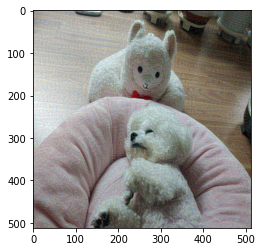

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32.914939880371094


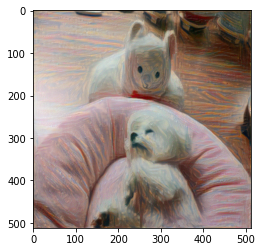

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23.8895263671875


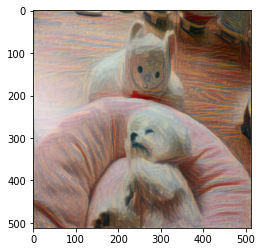

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31.91631317138672


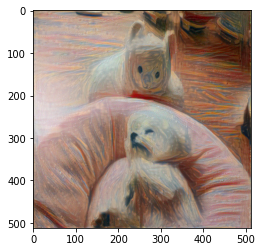

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18.12020492553711


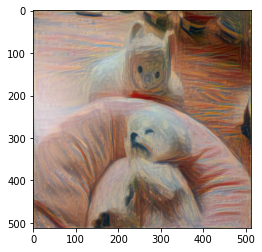

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


57.283695220947266


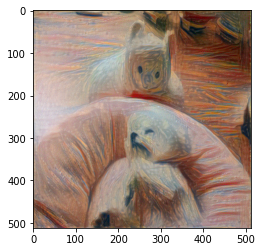

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26.13606834411621


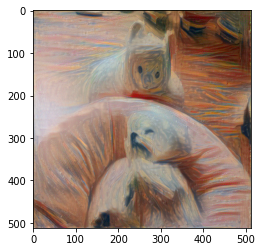

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20.6229190826416


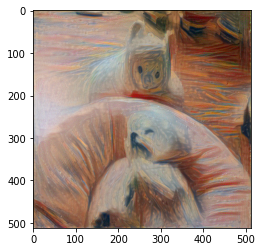

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23.469104766845703


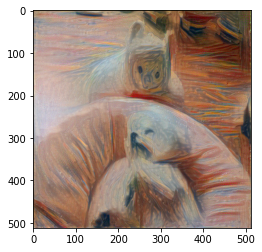

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14.909347534179688


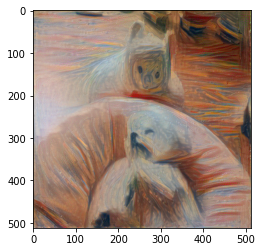

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29.2530517578125


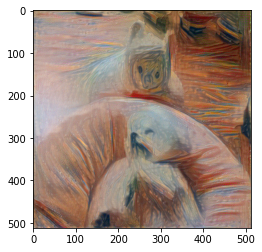

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12.490516662597656


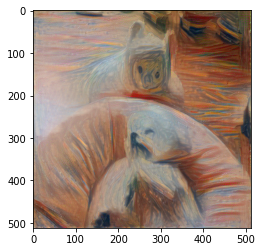

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39.09331512451172


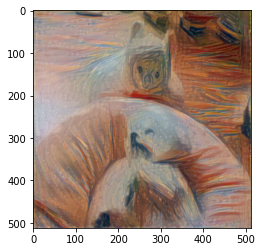

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20.300228118896484


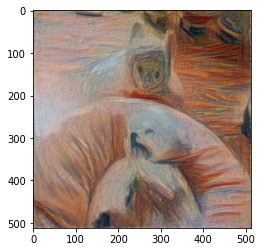

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24.47507095336914


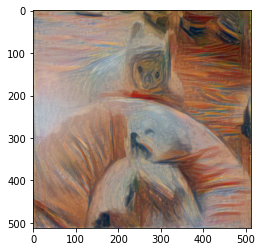

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27.11724090576172


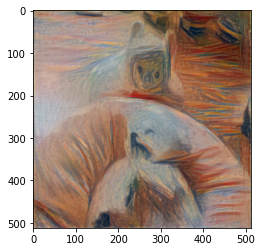

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21.581497192382812


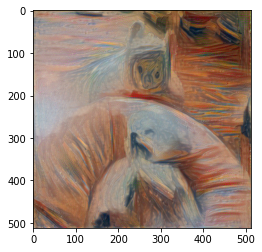

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28.37482261657715


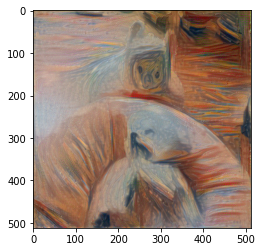

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29.136516571044922


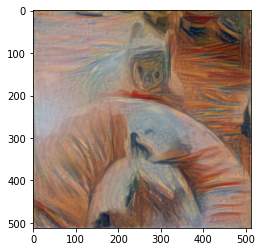

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24.018287658691406


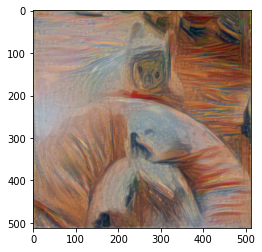

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20.661455154418945


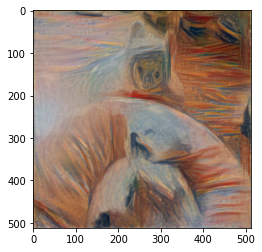

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25.984359741210938


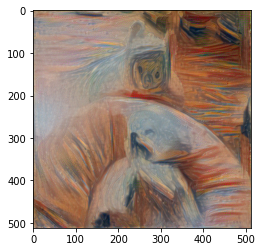

In [ ]:
max_iter = 10000
for i in tqdm(range(max_iter)):
    curr_loss = train(target_img, content_img_normalize, style_img_normalize, vgg, optimizer)
    if i % 100 == 0:
        print(curr_loss)
        plot_target(target_img)